# 20231203_pixel_to_graph

In [2]:
# load library
import stlearn as st
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import pandas as pd
import scipy.stats
import seaborn as sns
import plotly.express as px
from PIL import Image
import networkx as nx
import math

## Convertion from Xenium data to grids

In [3]:
# load the data
xenium_path = "/Volumes/Project/home/sakai/scRNA/20230518_Xenium/DATA/Xenium_Outputs/output-XETG00053__0003973__SQUAT-Case7__20230502__074131"

adata = st.ReadXenium(feature_cell_matrix_file=f"{xenium_path}/cell_feature_matrix.h5",
                     cell_summary_file=f"{xenium_path}/cells.csv.gz",
                     library_id="Case7_after_lung_panel",
                     image_path=None,
                     scale=1,
                     spot_diameter_fullres=10
                     )

In [4]:
# Gridding at 10μm interval
N_COL = int((adata.obs.imagecol.max() - adata.obs.imagecol.min()) / 10)
N_ROW = int((adata.obs.imagerow.max() - adata.obs.imagerow.min()) / 10)

# Gridding
grid = st.tl.cci.grid(adata, n_row=N_ROW, n_col=N_COL)

Gridding...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Extract tumor grids

In [6]:
# Extract CDH1 count
df_grid_cdh1 = grid.to_df()[["CDH1"]]

# complement nan grid
df_grid_cdh1 = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_cdh1, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPB count
df_grid_SFTPB = grid.to_df()[["SFTPB"]]

# complement nan grid
df_grid_SFTPB = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPB, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPC count
df_grid_SFTPC = grid.to_df()[["SFTPC"]]

# complement nan grid
df_grid_SFTPC = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPC, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPD count
df_grid_SFTPD = grid.to_df()[["SFTPD"]]

# complement nan grid
df_grid_SFTPD = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPD, right_index=True, left_index=True, how="left"
).fillna(0)

df_grid_cdh1["CDH1"] = [1 if i>=1 else -1 for i in df_grid_cdh1["CDH1"]]
df_grid_SFTPB["SFTPB"] = [1 if i>=1 else -1 for i in df_grid_SFTPB["SFTPB"]]
df_grid_SFTPC["SFTPC"] = [1 if i>=1 else -1 for i in df_grid_SFTPC["SFTPC"]]
df_grid_SFTPD["SFTPD"] = [1 if i>=1 else -1 for i in df_grid_SFTPD["SFTPD"]]

In [8]:
# Extract CDH1 count
df_grid_cdh1 = grid.to_df()[["CDH1"]]

# complement nan grid
df_grid_cdh1 = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_cdh1, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPB count
df_grid_SFTPB = grid.to_df()[["SFTPB"]]

# complement nan grid
df_grid_SFTPB = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPB, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPC count
df_grid_SFTPC = grid.to_df()[["SFTPC"]]

# complement nan grid
df_grid_SFTPC = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPC, right_index=True, left_index=True, how="left"
).fillna(0)

# Extract SFTPD count
df_grid_SFTPD = grid.to_df()[["SFTPD"]]

# complement nan grid
df_grid_SFTPD = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid_SFTPD, right_index=True, left_index=True, how="left"
).fillna(0)

df_grid_cdh1["CDH1"] = [1 if i>=1 else 0 for i in df_grid_cdh1["CDH1"]]
df_grid_SFTPB["SFTPB"] = [1 if i>=1 else 0 for i in df_grid_SFTPB["SFTPB"]]
df_grid_SFTPC["SFTPC"] = [1 if i>=1 else 0 for i in df_grid_SFTPC["SFTPC"]]
df_grid_SFTPD["SFTPD"] = [1 if i>=1 else 0 for i in df_grid_SFTPD["SFTPD"]]

# define tumor region
df_grid_cdh1["CDH1"] = df_grid_cdh1["CDH1"] - df_grid_SFTPB["SFTPB"] - df_grid_SFTPC["SFTPC"] - df_grid_SFTPD["SFTPD"]
df_grid_cdh1["CDH1"] = [-1 if i==0 else i for i in df_grid_cdh1["CDH1"]]

## Delineation of tumor surface

In [10]:
# median filter
img_cdh1_path = "./cdh1_density.png"
img_cdh1 = cv2.imread(img_cdh1_path)
img_cdh1_med = cv2.medianBlur(img_cdh1, ksize=3)

# save
cv2.imwrite("cdh1_density_median.png", img_cdh1_med)
# save zoom
#cv2.imwrite("cdh1_density_median_zoom.png", img_cdh1_med[300: 480, 400 : 580])

True

In [11]:
# delineation
img = "./cdh1_density_median.png"
threshold = 90 #二値化に用いる閾値
#threshold = 30 #二値化に用いる閾値

# glay scale
img_color = cv2.imread(img)
img_gray = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
img_blur = cv2.blur(img_gray,(3,3))

# delineation
ret, img_binary = cv2.threshold(img_blur, threshold, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_ = []
# check each delineation
for i, s in zip(contours, hierarchy[0]):
    # select top of hierarchy polygon
    if s[-1] == -1:
        #img_color_with_contours = cv2.drawContours(img_color, i, -1, (0,255,0), 1)
        contours_ += [i]

img_color_with_contours = cv2.drawContours(img_color, contours_, -1, (0,255,0), 1)
# save
cv2.imwrite("cdh1_density_delineation.png", img_color_with_contours)
# save zoom
#cv2.imwrite("cdh1_density_delineation_zoom.png", img_color_with_contours[300: 480, 400 : 580])

True

## Conversion from grids to graph

In [12]:
# 画像を読み込む
image = Image.open("cdh1_density_delineation.png")

# 画像サイズを取得
width, height = image.size

# 新しい有向グラフを作成
graph = nx.Graph()

tumor_contour_pixel_ls = []
tumor_pixel_ls = []
# ピクセルをノードに変換
for y in range(height):
    for x in range(width):
        pixel_value = image.getpixel((x, y))
        graph.add_node((x, y), color=pixel_value)

        # extract tumor coutour coordination
        if pixel_value == (0, 255, 0):
            tumor_contour_pixel_ls += [(x, y)]

        # extract tumor coordination
        elif pixel_value == (253, 231, 36):
            tumor_pixel_ls += [(x, y)]

# get nodes
nodes_ls = graph.nodes
nodes_ls = list(nodes_ls)

# check node inside contour
inside_contour_ls = []
for node in nodes_ls:
    for i in contours_:
        if cv2.pointPolygonTest(i, node, False) == 1:
            inside_contour_ls += [node]
            break

# extract tumor inside contour
tumor_pixel_ls = [i for i in tumor_pixel_ls if i in inside_contour_ls]

# extract non-tumor inside contour
nontumor_pixel_inside_contour_ls = [i for i in inside_contour_ls if i not in tumor_pixel_ls]

# 隣接ピクセル間にエッジを作成
for y in range(height):
    for x in range(width):
        current_node = (x, y)
        neighbors = [
            (x, y - 1),  # 上
            (x, y + 1),  # 下
            (x - 1, y),  # 左
            (x + 1, y)   # 右
        ]
        # 上下左右のエッジ
        for neighbor in neighbors:
            if neighbor in graph.nodes:
                graph.add_edge(current_node, neighbor)

        # 斜めのエッジ
        if (y != height) & (x != width):
            node1 = (x, y)
            node2 = (x + 1, y + 1)

            # ノードの座標からユークリッド距離を計算
            distance = math.sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)
            graph.add_edge(node1, node2, weight=distance)

            node1 = (x + 1, y)
            node2 = (x, y + 1)

            # ノードの座標からユークリッド距離を計算
            distance = math.sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)
            graph.add_edge(node1, node2, weight=distance)


#remove non-tumor inside contour from graph
graph.remove_nodes_from(nontumor_pixel_inside_contour_ls)

## Calculate distance of each nodes from tumor surface

In [13]:
# Calculate distance of each nodes from tumor surface
# ある一点からの最短距離を計算（cutoff=16）
shortest_paths = nx.multi_source_dijkstra(graph, tumor_contour_pixel_ls, cutoff=16, weight="weight")

# shotest length from contour
df_shotest = pd.DataFrame.from_dict(shortest_paths[0], orient="index", columns=["euclidean"])

# negative value for inside contour
df_shotest.loc[tumor_pixel_ls] = df_shotest.loc[tumor_pixel_ls] * -1
df_shotest["euclidean_round"] = df_shotest["euclidean"].round(0)
df_nodes = pd.DataFrame(index=nodes_ls)

df_shotest = pd.merge(
    df_nodes, df_shotest, right_index=True, left_index=True, how="left"
).fillna(np.nan)

In [14]:
# set the colormap and centre the colorbar
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [251]:
# delineation of contours
img = "./shotest.png"
threshold = 90 #二値化に用いる閾値

# glay scale
img_color = cv2.imread(img)

img_color_with_contours = cv2.drawContours(img_color, contours_, -1, (0,0,0), 1)
# save
cv2.imwrite("shotest_delineation.png", img_color_with_contours)
# save zoom
cv2.imwrite("cdh1_density_delineation_zoom.png", img_color_with_contours[305: 430, 405 : 530])

True

In [252]:
# plot each region
col_ls = []
for i in df_shotest["euclidean_round"]:
    if i == 0:
        col_ls += [(0, 255, 0)]
        #col_ls += [(0, 0, 255)]
    elif i % 3 == 0:
        #col_ls += [(0, 255, 255)]
        col_ls += [(0, 0, 255)]
    else:
        col_ls += [(0, 0, 0)]
        #col_ls += [(138, 79, 117)]

col_arr = np.array(col_ls, dtype=np.uint8).reshape(N_ROW, N_COL, 3)
img_color_with_contours = cv2.drawContours(col_arr, contours_, -1, (0,255,0), 1)

# save
cv2.imwrite("shotest_30_delineation.png", img_color_with_contours)

cv2.imwrite("shotest_30_delineation_zoom.png", img_color_with_contours[305: 430, 405 : 530])

True

## Region separation

In [26]:
# 離散化
df_shotest["region"] = pd.cut(
    df_shotest.dropna()["euclidean"], 
    bins=list(range(-15, 16, 3))
)

In [253]:
# plot each region
for i in df_shotest.dropna().region.value_counts()[df_shotest.dropna().region.value_counts() > 50].sort_index().index:
        
    col_ls = []
    for s in df_shotest["region"]:
        if s == i:
            col_ls += [(255, 255, 255)]
        else:
            col_ls += [(0, 0, 0)]
    
    col_arr = np.array(col_ls, dtype=np.uint8).reshape(N_ROW, N_COL, 3)
    img_color_with_contours = cv2.drawContours(col_arr, contours_, -1, (0,255,0), 1)
    
    # save
    #cv2.imwrite(f"shotest_region_{i}_delineation.png", img_color_with_contours)

    cv2.imwrite(f"shotest_region_{i}_delineation_zoom.png", img_color_with_contours[305: 430, 405 : 530])

## Region annotation to expression data of Xenium

In [30]:
df_grid = grid.to_df()

# complement nan grid
df_grid = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid, right_index=True, left_index=True, how="left"
).fillna(np.nan)

df_region = pd.DataFrame(
    np.array(df_shotest["region"]).reshape(N_ROW, N_COL).T.reshape(N_ROW * N_COL), 
    index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)], columns=["region"]
)

df_grid_region = pd.merge(
    df_grid, df_region, 
    right_index=True, left_index=True, how="left"
)

## Cell base analysis

In [ ]:
# table
df_grid = grid.to_df()

for i in df_grid.index:
    if (df_grid.loc[i, "CXCL13"] >= 2) & (df_grid.loc[i, "CD8A"] >= 2):
        df_grid.loc[i, "CXCL13+CD8+"] = 1

    elif (df_grid.loc[i, "CXCL13"] == 0) & (df_grid.loc[i, "CD8A"] >= 2):
        df_grid.loc[i, "CXCL13-CD8+"] = 1
    

df_grid = df_grid.fillna(0)

# onehot encording
df_grid_region_onehot = pd.get_dummies(
    df_grid_region["region"].dropna(), dtype=int
)

# 存在するものだけ
df_grid_region_onehot = df_grid_region_onehot[df_grid_region_onehot.index.isin(df_grid.index)]

df_grid_region_onehot = df_grid_region_onehot.loc[
    :, df_shotest.dropna().region.value_counts()[df_shotest.dropna().region.value_counts() > 50].sort_index().index
]

# * 10
df_grid_region_onehot.columns = [i*10 for i in df_shotest.dropna().region.value_counts()[df_shotest.dropna().region.value_counts() > 50].sort_index().index]

minus_ls = []
plus_ls = []

for i in df_grid_region_onehot.columns:
    df_temp_cxcl13_minus = df_grid.loc[df_grid_region_onehot.groupby(i).get_group(1).index, ["CXCL13-CD8+"]]
    df_temp_cxcl13_plus = df_grid.loc[df_grid_region_onehot.groupby(i).get_group(1).index, ["CXCL13+CD8+"]]

    minus_ls += [len(df_temp_cxcl13_minus[df_temp_cxcl13_minus["CXCL13-CD8+"] == 1]) / len(df_temp_cxcl13_minus)]
    plus_ls += [len(df_temp_cxcl13_plus[df_temp_cxcl13_plus["CXCL13+CD8+"] == 1]) / len(df_temp_cxcl13_plus)]

df_res = pd.DataFrame(
    [minus_ls, plus_ls], 
    columns=df_grid_region_onehot.columns, 
    index=["CXCL13-CD8+", "CXCL13+CD8+"]
).T

In [119]:
df_res_prop = df_res.apply(lambda x: x / sum(x))

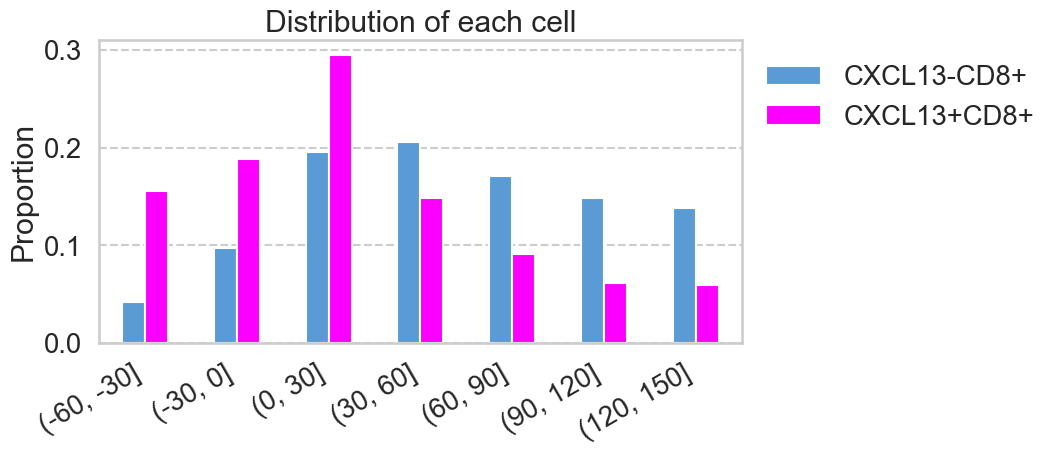

In [176]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize=(11, 5))

df_res_prop.plot.bar(stacked=False, ax=ax, color=["#5B9BD5", "#FB00FF"])
ax.set_ylabel("Proportion")
ax.set_title("Distribution of each cell")
fig.autofmt_xdate(rotation=30)
ax.xaxis.grid(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig("CXCL13CD8_grid_prop_region_prop.png", dpi=500)